In [216]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_eqtls")

source("script/packages.R"  )
source("script/input_data.R")
source("script/functions.R" )

dir.create("pipeline/4.13.heart_failure/ridge_vs_all", showWarnings = FALSE)


# Input CVPC + adult

In [219]:
metadata   =              fread("pipeline/3.1.covariates/metadata.txt"     , sep = "\t", header = TRUE , data.table = FALSE)
covariates = add_rownames(fread("pipeline/3.1.covariates/covariates.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
int_list   = readLines         ("pipeline/3.2.eqtls/vars/cardiac_eqtls.txt")
covariates = covariates[, grepl("^peer", colnames(covariates)) == FALSE & grepl("^cibersort.combined", colnames(covariates)) == FALSE & grepl("^pc", colnames(covariates)) == FALSE]
gene_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_gene.normalized.txt"   , sep = "\t", header = TRUE , data.table = FALSE))
isof_tpm   = add_rownames(fread("pipeline/1.2.expression/tpm_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))
isof_use   = add_rownames(fread("pipeline/1.2.expression/use_isoform.normalized.txt", sep = "\t", header = TRUE , data.table = FALSE))

colnames(covariates) = gsub("cibersort.regular\\.", "", colnames(covariates))

covariates$hf = 0
covariates$nf = 0


In [220]:

gene_info               = fread("input/phenotypes/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("input/phenotypes/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

diffgene = fread(paste("pipeline/4.1.differential_expression", "diffexp.txt"     , sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
diffcell = fread(paste("pipeline/4.1.differential_expression", "diffexp_cell.txt", sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)

diffgene$diffexp = FALSE
diffgene[diffgene$qval < 0.05, "diffexp"] = TRUE


# Input heart failure

In [235]:
meta4            = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/SraRunTable_GSE46224.txt", sep = "\t", header = TRUE, data.table = FALSE)
colnames(meta4)  = tolower(gsub(" ", "_", colnames(meta4)))
meta4            = meta4[,c("run", "name", "age", "sex", "lvad_support")]
meta4$subject_id = gsub("_LVAD", "", meta4$name)

meta4 = meta4[!meta4$run %in% c("SRR830992", "SRR830976"),]
meta4$hf = 0
meta4[ meta4$lvad_support == "pre-LVAD", "hf"] = 1

gene_tpm_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/tpm_gene.normalized.txt"  , sep = "\t", header = TRUE , data.table = FALSE))
isof_use_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/use_isoform.expressed.txt", sep = "\t", header = TRUE , data.table = FALSE))

#gene_tpm_hf   = gene_tpm_hf[,meta4$run]
#isof_use_hf   = isof_use_hf[,meta4$run]

meta4       = meta4[ meta4$lvad_support != "nil",]
gene2sd     = data.frame(gene_id = rownames(gene_tpm_hf), sd = unlist(apply(gene_tpm_hf, 1, sd)), median = unlist(apply(gene_tpm_hf, 1, median)), sd_hf = unlist(apply(gene_tpm_hf[, meta4$run], 1, sd)), median_hf = unlist(apply(gene_tpm_hf[, meta4$run], 1, median)))
isof2sd     = data.frame(gene_id = rownames(isof_use_hf), sd = unlist(apply(isof_use_hf, 1, sd)), median = unlist(apply(isof_use_hf, 1, median)), sd_hf = unlist(apply(isof_use_hf[, meta4$run], 1, sd)), median_hf = unlist(apply(isof_use_hf[, meta4$run], 1, median)))
gene_tpm_hf = gene_tpm_hf[rownames(gene_tpm_hf) %in% gene2sd[ gene2sd$sd > 0 & gene2sd$sd_hf > 0, "gene_id"],]
isof_use_hf = isof_use_hf[rownames(isof_use_hf) %in% isof2sd[ isof2sd$sd > 0 & isof2sd$sd_hf > 0 & isof2sd$median > 0 & isof2sd$median < 100 & isof2sd$median_hf > 0, "gene_id"],]


In [236]:
cibersort_hf  = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/2.1.scrna_seq/cibersort.new.txt", sep = "\t", header = TRUE, data.table = FALSE))
flagstat_hf   = add_rownames(fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/input/phenotypes/combined/flagstat.txt"  , sep = "\t", header = TRUE, data.table = FALSE))

cibersort_hf[,c("P-value", "Correlation", "RMSE")] = NULL
colnames(cibersort_hf) = gsub("leukocyte", "immune", gsub("_cell", "", colnames(cibersort_hf)))
cell2color_hf          = data.frame(cell_type = colnames(cibersort_hf), color = NA) 
cibersort_hf           = cibersort_hf[ meta4$run,]

covariates_hf = add_rownames(merge(cibersort_hf , flagstat_hf, by = "row.names"))
covariates_hf = add_rownames(merge(covariates_hf, meta4[,c("run", "sex", "age", "hf")], by.x = "row.names", by.y = "run"))
                                                        

covariates_hf$total_reads_norm                              = covariates_hf$total_reads / mean(covariates_hf$total_reads)
covariates_hf$uniquely_mapped_reads_to_canonical_chromsomes = rowSums(covariates_hf[,c("autosomal_reads", "chrX_reads", "chrY_reads")]) / covariates_hf$total_reads
covariates_hf$mitochondrial_reads                           = covariates_hf$chrM_reads / covariates_hf$total_reads

covariates_hf = covariates_hf[,c(cell2color_hf$cell_type, "total_reads_norm", "uniquely_mapped_reads_to_canonical_chromsomes", "mitochondrial_reads", "sex", "age")]

covariates_hf$sex = as.numeric(suppressMessages(mapvalues(covariates_hf$sex, from=c("male", "female"), to = 0:1)))

covariates_hf$hf = 0
covariates_hf[ meta4[ meta4$hf == 1, "run"], "hf"] = 1
covariates_hf[,c("ipsc_cvpc", "heart", "arteria")] = 0
covariates_hf$nf = abs(1-covariates_hf$hf)


# All input data

In [237]:
mycols         = intersect(colnames(covariates), colnames(covariates_hf))
covariates_all = rbind(covariates[,mycols], covariates_hf[,mycols])

# Test cell proportion differences

In [341]:
test_cell_proportions = function(covariates, tissue1, tissue2, cell)
{
    this = covariates[covariates[,tissue1] == 1 | covariates[, tissue2] == 1,]
    this = data.frame(cell = this[,cell], tissue = this[,tissue1])
    
    test = t.test(this[this$tissue == 1, "cell"], this[this$tissue == 0, "cell"])
    
    out = data.frame(tissue1 = tissue1, tissue2 = tissue2, cell = cell, mean_tissue1 = test$estimate[[1]], mean_tissue2 = test$estimate[[2]], ci1 = test$conf.int[[1]], ci2 = test$conf.int[[2]], log2r = log2(test$estimate[[1]] / test$estimate[[2]]), pval = test$p.value)
    
    return(out)
}

tissue1 = "hf"
tissue2 = "nf"
cell    = "cardiac_muscle"

test_cells = as.data.frame(rbindlist(lapply(cell2color_hf$cell_type, function(cell)
{
    out1 = test_cell_proportions(covariates_hf , "hf", "nf"       , cell)
    out2 = test_cell_proportions(covariates_all, "hf", "ipsc_cvpc", cell)
    out3 = test_cell_proportions(covariates_all, "hf", "heart"    , cell)
    out4 = test_cell_proportions(covariates_all, "hf", "arteria"  , cell)
    out5 = test_cell_proportions(covariates_all, "nf", "heart"    , cell)
    
    return(rbind(out1, out2, out3, out4, out5))

})), stringsAsFactors = FALSE)

test_cells$qval = p.adjust(test_cells$pval, method = "BH")

In [350]:
fwrite(test_cells, "pipeline/4.13.heart_failure/ridge_vs_all/tests_cell_type_proportions.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

# Differential expression heart failure

In [240]:
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(hdi))



In [241]:
# Analysis
run_diffexp_ridge_lm = function(gene_id, x, covariates)
{
    covariates$exp = as.numeric(x[gene_id, rownames(covariates)])
    
    mylm = ridge.proj(x = as.matrix(covariates[, colnames(covariates) != "exp"]), y = covariates$exp, suppress.grouptesting = FALSE)
    out  = data.frame(transcript_id = gene_id, covariate = names(mylm$pval), beta = mylm$bhat, se = mylm$se, pval = mylm$pval)
    
    return(out)
}

run_diffexp = function(x, name, covariates, tissue1, tissue2)
{
	message(paste(name, tissue1, tissue2))
	
	covariates        = covariates[ rowSums(covariates[,c(tissue1, tissue2)]) > 0,]
	covariates$tissue = 0
	
	covariates[covariates[,tissue1] == 1, "tissue"] = 1
    
    covariates[,c("ipsc_cvpc", "heart", "arteria", "hf", "nf")] = NULL
    
	x                 = x[,rownames(covariates)]
	diffexp           = as.data.frame(rbindlist(lapply(rownames(x), function(gene_id){run_diffexp_ridge_lm(gene_id, x, covariates)})), stringsAsFactors = FALSE)
	diffexp$qval      = p.adjust(diffexp$pval, method = "bonferroni") 
	diffexp$tissue1   = tissue1
	diffexp$tissue2   = tissue2
    
	fwrite(diffexp, paste("pipeline/4.13.heart_failure/ridge_vs_all", paste("diffexp", name, tissue1, tissue2, "txt", sep = "."), sep = "/"), sep = "\t", col.names = TRUE, row.names = FALSE)
}

invisible(lapply(c("ipsc_cvpc", "heart", "arteria", "nf"), function(tissue2)
{
	lapply(c("gene_tpm", "isoform_use"), function(type)
	{
		expdata = gene_tpm_hf
        if(type == "isoform_use"){expdata = isof_use_hf}
        
        #run_diffexp(expdata, type, covariates_all, "hf", tissue2)
	})
}))


In [300]:
gene_info               = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/gene_info.txt"   , sep = "\t", header = TRUE, data.table = FALSE)
isof_info               = fread("/frazer01/projects/CARDIPS/analysis/heart_failure_gene_expression/pipeline/1.2.expression/isoform_info.txt", sep = "\t", header = TRUE, data.table = FALSE)
gene_info$transcript_id = gene_info$gene_id

read_diffexp = function(name, tissue1, tissue2, gene_info)
{
    indata               = fread(paste("pipeline/4.13.heart_failure/ridge_vs_all", paste("diffexp", name, tissue1, tissue2, "txt", sep = "."), sep = "/"), sep = "\t", header = TRUE, data.table = FALSE)
    indata               = indata[order(indata$pval),]
    indata               = merge(gene_info[,c("transcript_id", "gene_id", "gene_name", "gene_type")], indata)
    indata$qval          = p.adjust(indata$pval / length(unique(indata$covariate)), method = "bonferroni")
    indata$type          = name
    indata$diffexp       = FALSE
    
    if(nrow(indata[indata$qval < 0.05,]) > 0){indata[indata$qval < 0.05, "diffexp"] = TRUE}
    
    message(paste(name, tissue1, tissue2, nrow(indata), nrow(indata[indata$qval < 0.05,])))
    return(indata)
}

diffexp = as.data.frame(rbindlist(lapply(c("ipsc_cvpc", "heart", "arteria", "nf"), function(tissue2)
{
	as.data.frame(rbindlist(lapply(c("gene_tpm", "isoform_use"), function(type)
	{
		info_data = gene_info
        if(type == "isoform_use"){info_data = isof_info}
        
        out = read_diffexp(type, "hf", tissue2, info_data)
        
        return(out)
	})), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)
fwrite(diffexp, "pipeline/4.13.heart_failure/ridge_vs_all/diffexp.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


gene_tpm hf ipsc_cvpc 283808 3961

isoform_use hf ipsc_cvpc 407540 1833

gene_tpm hf heart 283794 14663

isoform_use hf heart 407540 14162

gene_tpm hf arteria 283794 10577

isoform_use hf arteria 407540 7573

gene_tpm hf nf 283794 245

isoform_use hf nf 140 1



# Functional enrichment analysis

In [306]:
diffgene = diffexp[ diffexp$covariate == "tissue",]

In [310]:
gmt2list = function(gs)
{    
    indata = readLines(paste("input/phenotypes/msigdb", paste(gs, "v7.1.symbols.gmt", sep = "."), sep = "/"))
    indata = lapply(indata, function(x)
    {
        this = unlist(strsplit(x, "\t"))
        out  = list(gene_set = this[[1]], url = this[[2]], gene_names = this[3:length(this)])
        
        return(out)
    })
    names(indata) = unlist(lapply(indata, function(x){x$gene_set}))
    
    return(indata)
}

msigdb               = c("c2.cp.biocarta", "c2.cp.kegg", "c2.cp.reactome", "c5.bp", "c5.cc", "c5.mf", "h.all")
#msigdb               = c("h.all")
genesets2test        = lapply(msigdb, gmt2list)
names(genesets2test) = msigdb


In [311]:
calculate_functional_enrichment_tissue_by_gene_set = function(tissue1, tissue2, type, gs, gene_set, diffgene)
{
    diffexp    = diffgene[diffgene$type == type & diffgene$tissue1 == tissue1 & diffgene$tissue2 == tissue2,]
    out        = data.frame(tissue1 = tissue1, tissue2 = tissue2, type = type, gs_source = gs, gene_set = gene_set[["gene_set"]], url = gene_set[["url"]], ngenes = length(gene_set[["gene_names"]]))
    genes_in   = gene_set[["gene_names"]]
    diffexp$gs = FALSE
    
    if(nrow(diffexp[diffexp$gene_name %in% genes_in,]) > 1)
    {
        diffexp[diffexp$gene_name %in% genes_in, "gs"] = TRUE

        test = t.test(diffexp[diffexp$gs == TRUE, "beta"], diffexp[diffexp$gs == FALSE, "beta"])
        out  = cbind(out, data.frame(ttest_estimate_in = test$estimate[[1]], ttest_estimate_out = test$estimate[[2]], ttest_ci1 = test$conf.int[[1]], ttest_ci2 = test$conf.int[[2]], ttest_pval = test$p.value))

        tofisher = matrix(0, nrow = 3, ncol = 2)
        rownames(tofisher) = c("over", "under", "no")
        colnames(tofisher) = c("yes", "no")

        tofisher["over" , "yes"] = nrow(diffexp[diffexp$qval < 0.05 & diffexp$beta > 0 & diffexp$gs == TRUE ,])
        tofisher["over" , "no" ] = nrow(diffexp[diffexp$qval < 0.05 & diffexp$beta > 0 & diffexp$gs == FALSE,])
        tofisher["under", "yes"] = nrow(diffexp[diffexp$qval < 0.05 & diffexp$beta < 0 & diffexp$gs == TRUE ,])
        tofisher["under", "no" ] = nrow(diffexp[diffexp$qval < 0.05 & diffexp$beta < 0 & diffexp$gs == FALSE,])
        tofisher["no"   , "yes"] = nrow(diffexp[diffexp$qval > 0.05                    & diffexp$gs == TRUE ,])
        tofisher["no"   , "no" ] = nrow(diffexp[diffexp$qval > 0.05                    & diffexp$gs == FALSE,])

        test_up = fisher.test(tofisher[c("over" , "no"),])
        test_dn = fisher.test(tofisher[c("under", "no"),])

        out  = cbind(out, data.frame(fisher_up_estimate = test_up$estimate, fisher_up_ci1 = test_up$conf.int[[1]], fisher_up_ci2 = test_up$conf.int[[2]], fisher_up_pval = test_up$p.value))
        out  = cbind(out, data.frame(fisher_dn_estimate = test_dn$estimate, fisher_dn_ci1 = test_dn$conf.int[[1]], fisher_dn_ci2 = test_dn$conf.int[[2]], fisher_dn_pval = test_dn$p.value))
    }else
    {
        out  = cbind(out, data.frame(ttest_estimate_in  = NA, ttest_estimate_out = NA, ttest_ci1     = NA, ttest_ci2      = NA, ttest_pval = NA))
        out  = cbind(out, data.frame(fisher_up_estimate = NA, fisher_up_ci1      = NA, fisher_up_ci2 = NA, fisher_up_pval = NA))
        out  = cbind(out, data.frame(fisher_dn_estimate = NA, fisher_dn_ci1      = NA, fisher_dn_ci2 = NA, fisher_dn_pval = NA))

    }
    return(out)
}

#tests = as.data.frame(rbindlist(lapply(sort(unique(diffgene$type)), function(type)
tests = as.data.frame(rbindlist(lapply(c("gene_tpm"), function(type)
{
    as.data.frame(rbindlist(lapply(msigdb, function(gs)
    {
        message(paste(type, gs))
        gene_sets = genesets2test[[gs]]
        as.data.frame(rbindlist(lapply(gene_sets, function(gene_set)
        {
            #message(gene_set[["gene_set"]])
			#calculate_functional_enrichment_tissue_by_gene_set("ipsc_cvpc", "heart"  , type, gs, gene_set, diffgene)
            out = rbind(calculate_functional_enrichment_tissue_by_gene_set("hf", "ipsc_cvpc", type, gs, gene_set, diffgene),
                        calculate_functional_enrichment_tissue_by_gene_set("hf", "heart"    , type, gs, gene_set, diffgene),
                        calculate_functional_enrichment_tissue_by_gene_set("hf", "arteria"  , type, gs, gene_set, diffgene),
                        calculate_functional_enrichment_tissue_by_gene_set("hf", "nf"       , type, gs, gene_set, diffgene)
                       )
            return(out)
        })), stringsAsFactors = FALSE)
    })), stringsAsFactors = FALSE)
})), stringsAsFactors = FALSE)

tests = tests[is.na(tests$ttest_estimate_in) == FALSE, ]

tests$ttest_fdr     = p.adjust(tests$ttest_pval    , method = "BH")
tests$fisher_up_fdr = p.adjust(tests$fisher_up_pval, method = "BH")
tests$fisher_dn_fdr = p.adjust(tests$fisher_dn_pval, method = "BH")

fwrite(tests, "pipeline/4.13.heart_failure/ridge_vs_all/functional_enrichment.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


gene_tpm c2.cp.biocarta

gene_tpm c2.cp.kegg

gene_tpm c2.cp.reactome

gene_tpm c5.bp

gene_tpm c5.cc

gene_tpm c5.mf

gene_tpm h.all



# Differential isoform analysis
- 1 = iPSC-CVPC vs. adult heart
- 2 = heart failure vs. iPSC-CVPC
- 3 = heart failure vs adult heart

In [302]:
diffexp_de = fread("pipeline/4.15.differential_expression_ridge/diffexp.txt", sep = "\t", header = TRUE, data.table = FALSE)
difrbp_de  = diffexp_de[diffexp_de$gene_name %in% rbps & diffexp_de$covariate == "tissue",]


In [326]:
diffiso = unique(diffexp[ diffexp$type == "isoform_use", c("transcript_id", "gene_id", "gene_name")])
diffiso = merge(diffiso, diffexp_de[ diffexp_de$covariate == "tissue" & diffexp_de$type == "isoform_use" & diffexp_de$tissue1 == "ipsc_cvpc" & diffexp_de$tissue2 == "heart"    , c("transcript_id", "beta", "pval", "qval", "diffexp")])
diffiso = merge(diffiso, diffexp   [ diffexp   $covariate == "tissue" & diffexp   $type == "isoform_use" & diffexp   $tissue1 == "hf"        & diffexp   $tissue2 == "ipsc_cvpc", c("transcript_id", "beta", "pval", "qval", "diffexp")], by = "transcript_id", suffixes = 1:2)
diffiso = merge(diffiso, diffexp   [ diffexp   $covariate == "tissue" & diffexp   $type == "isoform_use" & diffexp   $tissue1 == "hf"        & diffexp   $tissue2 == "heart"    , c("transcript_id", "beta", "pval", "qval", "diffexp")], by = "transcript_id")

colnames(diffiso)[(ncol(diffiso) - 3):ncol(diffiso)] = paste(colnames(diffiso)[(ncol(diffiso) - 3):ncol(diffiso)], 3, sep = "")



In [339]:
plot_diffiso = function(diffiso, x1, x2)
{
    todif   = data.frame(x = 1:3, name = c("iPSC-CVPC vs. adult heart", "heart failure vs. iPSC-CVPC", "heart failure vs adult heart"))
    todif   = todif[c(x1, x2),]
    diffiso = diffiso[, c("transcript_id", "gene_id", "gene_name", paste(c("beta", "pval", "qval", "diffexp"), x1, sep = ""), paste(c("beta", "pval", "qval", "diffexp"), x2, sep = ""))]
    colnames(diffiso) = c("transcript_id", "gene_id", "gene_name", paste(c("beta", "pval", "qval", "diffexp"),  1, sep = ""), paste(c("beta", "pval", "qval", "diffexp"), 2, sep = ""))
    
    totest = data.frame(x = c("N.S.", 
                              paste("Differentially expressed only in", todif[1,"name"]),
                              paste("Differentially expressed only in", todif[2,"name"]),
                              paste("Differentially expressed in both (same direction)"),
                              paste("Differentially expressed in both (different direction)")
                             ),
                        
                        n = c(nrow(diffiso[diffiso$diffexp1 == FALSE & diffiso$diffexp2 == FALSE,]),
                              nrow(diffiso[diffiso$diffexp1 == TRUE  & diffiso$diffexp2 == FALSE,]),
                              nrow(diffiso[diffiso$diffexp1 == FALSE & diffiso$diffexp2 == TRUE ,]),
                              nrow(diffiso[diffiso$diffexp1 == TRUE  & diffiso$diffexp2 == TRUE  & sign(diffiso$beta1) == sign(diffiso$beta2),]),
                              nrow(diffiso[diffiso$diffexp1 == TRUE  & diffiso$diffexp2 == TRUE  & sign(diffiso$beta1) != sign(diffiso$beta2),])
                             )
                       )
    
    return(totest)
}

plot_diffiso(diffiso, 1, 2)
plot_diffiso(diffiso, 1, 3)
plot_diffiso(diffiso, 2, 3)


x,n
<chr>,<int>
N.S.,17743
Differentially expressed only in iPSC-CVPC vs. adult heart,10059
Differentially expressed only in heart failure vs. iPSC-CVPC,220
Differentially expressed in both (same direction),18
Differentially expressed in both (different direction),539


x,n
<chr>,<int>
N.S.,16436
Differentially expressed only in iPSC-CVPC vs. adult heart,8875
Differentially expressed only in heart failure vs adult heart,1527
Differentially expressed in both (same direction),1523
Differentially expressed in both (different direction),218


x,n
<chr>,<int>
N.S.,24698
Differentially expressed only in heart failure vs. iPSC-CVPC,613
Differentially expressed only in heart failure vs adult heart,3104
Differentially expressed in both (same direction),47
Differentially expressed in both (different direction),117


In [348]:
fisher.test(matrix(c(1523, 1527, 8875,16436), nrow = 2, byrow = TRUE))
fisher.test(matrix(c(1523, 1527, 8875,16436), nrow = 2, byrow = TRUE))$p.value
1523/3268

(8875+1523+218)
(8875+1523+218+16436+1527)

(8875+1523+218)/(8875+1523+1527+218+16436)





	Fisher's Exact Test for Count Data

data:  matrix(c(1523, 1527, 8875, 16436), nrow = 2, byrow = TRUE)
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.711394 1.993458
sample estimates:
odds ratio 
  1.847109 


[1] 1.570972e-56

[1] 0.4660343

[1] 10616

[1] 28579

[1] 0.3714616

In [328]:
cor.test(diffiso$beta1, diffiso$beta2)
cor.test(diffiso$beta1, diffiso$beta3)
cor.test(diffiso$beta2, diffiso$beta3)



	Pearson's product-moment correlation

data:  diffiso$beta1 and diffiso$beta2
t = -66.067, df = 28577, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3740222 -0.3539065
sample estimates:
       cor 
-0.3640068 



	Pearson's product-moment correlation

data:  diffiso$beta1 and diffiso$beta3
t = 46.613, df = 28577, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2550137 0.2765632
sample estimates:
      cor 
0.2658217 



	Pearson's product-moment correlation

data:  diffiso$beta2 and diffiso$beta3
t = -26.308, df = 28577, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1650708 -0.1424313
sample estimates:
       cor 
-0.1537712 


In [325]:
colnames(diffiso[, c("beta", "pval", "qval", "diffexp")])

[1] "beta"    "pval"    "qval"    "diffexp"

# differential expression plots

In [301]:
rbps   = readLines("pipeline/rbps.txt")
difrbp = diffexp[ diffexp$gene_name %in% rbps,]

tissues = unique(difrbp[,c("tissue1", "tissue2", "type")])

difrbp = as.data.frame(rbindlist(lapply(1:nrow(tissues), function(ii)
{
    tissue1 = tissues[ii, "tissue1"]
    tissue2 = tissues[ii, "tissue2"]
    type    = tissues[ii, "type"   ]
    
    out = difrbp[difrbp$tissue1 == tissue1 & difrbp$tissue2 == tissue2 & difrbp$type == type & difrbp$covariate == "tissue",]
    out$qval = p.adjust(out$pval, method = "BH")
    
    out[out$qval <= 0.05, "diffexp"] = TRUE
    
    return(out)
})), stringsAsFactors = FALSE)



In [303]:
test_rbp = function(x, tissue1, tissue2, type)
{
    x = x[x$tissue1 == tissue1 & x$tissue2 == tissue2 & x$type == type & x$covariate == "tissue",]
    
    test = t.test(x$beta, mu = 0)
    
    out = data.frame(type = type, tissue1 = tissue1, tissue2 = tissue2, estimate = test$estimate, pval = test$p.value)
    
    return(out)
    
}

tests1 = as.data.frame(rbindlist(lapply(c("gene_tpm", "isoform_use"), function(type)
{
    out1 = test_rbp(difrbp, "hf", "ipsc_cvpc", type)
    out2 = test_rbp(difrbp, "hf", "heart"    , type)
    out3 = test_rbp(difrbp, "hf", "arteria"  , type)
    
    out = as.data.frame(rbindlist(list(out1, out2, out3)), stringsAsFactors = FALSE)

})), stringsAsFactors = FALSE)

tests2= as.data.frame(rbindlist(lapply(c("gene_tpm", "isoform_use"), function(type)
{
    out1 = test_rbp(difrbp_de, "ipsc_cvpc", "heart"  , type)
    out2 = test_rbp(difrbp_de, "ipsc_cvpc", "arteria", type)
    out3 = test_rbp(difrbp_de, "heart"    , "arteria", type)
    
    out = as.data.frame(rbindlist(list(out1, out2, out3)), stringsAsFactors = FALSE)

})), stringsAsFactors = FALSE)

tests1
tests2


type,tissue1,tissue2,estimate,pval
<chr>,<chr>,<chr>,<dbl>,<dbl>
gene_tpm,hf,ipsc_cvpc,-0.2109068,0.272953739
gene_tpm,hf,heart,0.2231614,0.001277849
gene_tpm,hf,arteria,0.6693676,0.005109439
isoform_use,hf,ipsc_cvpc,-0.2960856,0.767792948
isoform_use,hf,heart,1.5093746,0.013897594
isoform_use,hf,arteria,2.0585151,0.286138119


type,tissue1,tissue2,estimate,pval
<chr>,<chr>,<chr>,<dbl>,<dbl>
gene_tpm,ipsc_cvpc,heart,0.84071870,2.015265e-13
gene_tpm,ipsc_cvpc,arteria,0.48809841,9.281278e-06
gene_tpm,heart,arteria,0.16285751,5.689867e-04
isoform_use,ipsc_cvpc,heart,0.20579909,8.866216e-07
isoform_use,ipsc_cvpc,arteria,0.09918655,9.425984e-02
isoform_use,heart,arteria,-0.03646675,1.225387e-01


In [304]:
rbp_data    = difrbp   [difrbp   $type == "gene_tpm" & difrbp   $covariate == "tissue" & difrbp   $tissue2 != "nf" & difrbp   $tissue2 != "arteria",]
rbp_data_de = difrbp_de[difrbp_de$type == "gene_tpm" & difrbp_de$covariate == "tissue" & difrbp_de$tissue2 != "nf" & difrbp_de$tissue2 != "arteria",]

genes = aggregate(diffexp ~ transcript_id + gene_id + gene_name, data = rbp_data, FUN = sum)
genes = genes[genes$diffexp > 1,]
genes = genes[order(genes$diffexp, decreasing = TRUE),]

head(genes, n = 10)

toplot1 = rbp_data   [rbp_data   $transcript_id %in% genes$transcript_id,]
toplot2 = rbp_data_de[rbp_data_de$transcript_id %in% genes$transcript_id,]
toplot1 = toplot1[order(toplot1$transcript_id),]
toplot2 = toplot2[order(toplot2$transcript_id),]

head(toplot1, n = 20)
head(toplot2, n = 20)



,transcript_id,gene_id,gene_name,diffexp
,<chr>,<chr>,<chr>,<int>
6,ENSG00000113742.14_6,ENSG00000113742.14_6,CPEB4,2
39,ENSG00000088247.17_6,ENSG00000088247.17_6,KHSRP,2
42,ENSG00000152601.17_6,ENSG00000152601.17_6,MBNL1,2
44,ENSG00000153944.11_8,ENSG00000153944.11_8,MSI2,2
51,ENSG00000169564.7_5,ENSG00000169564.7_5,PCBP1,2
55,ENSG00000148840.11_5,ENSG00000148840.11_5,PPRC1,2
57,ENSG00000011304.20_8,ENSG00000011304.20_8,PTBP1,2
60,ENSG00000134644.15_6,ENSG00000134644.15_6,PUM1,2
67,ENSG00000259956.2_4,ENSG00000259956.2_4,RBM15B,2


,transcript_id,gene_id,gene_name,gene_type,covariate,beta,se,pval,qval,tissue1,tissue2,type,diffexp
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
2,ENSG00000004534.15_5,ENSG00000004534.15_5,RBM6,protein_coding,tissue,2.6113021,0.6629830,8.191872e-05,5.216929e-04,hf,ipsc_cvpc,gene_tpm,TRUE
486,ENSG00000004534.15_5,ENSG00000004534.15_5,RBM6,protein_coding,tissue,-1.2641241,0.2814887,7.093881e-06,5.049174e-05,hf,heart,gene_tpm,TRUE
4,ENSG00000011304.20_8,ENSG00000011304.20_8,PTBP1,protein_coding,tissue,-2.2256597,0.6996656,1.467508e-03,5.728015e-03,hf,ipsc_cvpc,gene_tpm,TRUE
488,ENSG00000011304.20_8,ENSG00000011304.20_8,PTBP1,protein_coding,tissue,-0.7895559,0.2327831,6.943284e-04,2.545871e-03,hf,heart,gene_tpm,TRUE
6,ENSG00000020577.14_5,ENSG00000020577.14_5,SAMD4A,protein_coding,tissue,2.4824416,0.4865997,3.367763e-07,3.704540e-06,hf,ipsc_cvpc,gene_tpm,TRUE
490,ENSG00000020577.14_5,ENSG00000020577.14_5,SAMD4A,protein_coding,tissue,1.0612627,0.2199991,1.407493e-06,1.408783e-05,hf,heart,gene_tpm,TRUE
9,ENSG00000063244.12_6,ENSG00000063244.12_6,U2AF2,protein_coding,tissue,-4.7714530,1.1497002,3.322264e-05,2.364670e-04,hf,ipsc_cvpc,gene_tpm,TRUE
493,ENSG00000063244.12_6,ENSG00000063244.12_6,U2AF2,protein_coding,tissue,0.6993332,0.2718814,1.010547e-02,2.736944e-02,hf,heart,gene_tpm,TRUE
21,ENSG00000088247.17_6,ENSG00000088247.17_6,KHSRP,protein_coding,tissue,-3.1267464,0.5817153,7.656334e-08,9.777368e-07,hf,ipsc_cvpc,gene_tpm,TRUE


,transcript_id,gene_id,gene_name,gene_type,covariate,beta,se,pval,qval,tissue1,tissue2,type,diffexp
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
661,ENSG00000004534.15_5,ENSG00000004534.15_5,RBM6,protein_coding,tissue,-0.84045670,0.13297463,2.608386e-10,5.319281e-06,ipsc_cvpc,heart,gene_tpm,TRUE
3303,ENSG00000011304.20_8,ENSG00000011304.20_8,PTBP1,protein_coding,tissue,-1.03003136,0.11860709,3.807486e-18,7.764606e-14,ipsc_cvpc,heart,gene_tpm,TRUE
4596,ENSG00000020577.14_5,ENSG00000020577.14_5,SAMD4A,protein_coding,tissue,-1.45538466,0.11667123,1.031884e-35,2.104321e-31,ipsc_cvpc,heart,gene_tpm,TRUE
9942,ENSG00000063244.12_6,ENSG00000063244.12_6,U2AF2,protein_coding,tissue,0.36637552,0.17511746,3.642330e-02,1.000000e+00,ipsc_cvpc,heart,gene_tpm,FALSE
20445,ENSG00000088247.17_6,ENSG00000088247.17_6,KHSRP,protein_coding,tissue,1.43677447,0.12856089,5.354832e-29,1.092011e-24,ipsc_cvpc,heart,gene_tpm,TRUE
48218,ENSG00000113742.14_6,ENSG00000113742.14_6,CPEB4,protein_coding,tissue,-0.00465661,0.15231231,9.756103e-01,1.000000e+00,ipsc_cvpc,heart,gene_tpm,FALSE
77334,ENSG00000134644.15_6,ENSG00000134644.15_6,PUM1,protein_coding,tissue,1.74394518,0.15869579,4.305639e-28,8.780490e-24,ipsc_cvpc,heart,gene_tpm,TRUE
86710,ENSG00000139168.8_8,ENSG00000139168.8_8,ZCRB1,protein_coding,tissue,0.30123716,0.20728345,1.461510e-01,1.000000e+00,ipsc_cvpc,heart,gene_tpm,FALSE
101131,ENSG00000148840.11_5,ENSG00000148840.11_5,PPRC1,protein_coding,tissue,-0.52331342,0.20979201,1.261563e-02,1.000000e+00,ipsc_cvpc,heart,gene_tpm,FALSE


# OLD

**********************************
All genes

gene_tpm ipsc_cvpc nf 0.0717932938447829 1.39287406243676e-24

gene_tpm heart nf 0.286884767165334 0

gene_tpm arteria nf 0.0948152845526705 1.05304934993622e-41

gene_tpm ipsc_cvpc heart 0.32099416168769 0

gene_tpm ipsc_cvpc arteria 0.12792129908908 1.05028865364125e-74

gene_tpm heart arteria 0.451278043314845 0

**********************************
RBPs

gene_tpm ipsc_cvpc nf -0.0641493653904627 0.484527713679905

gene_tpm heart nf 0.369619002267244 3.01474717418135e-05

gene_tpm arteria nf 0.034576500782647 0.706540623186732

gene_tpm ipsc_cvpc heart 0.0880620080006738 0.336806267610429

gene_tpm ipsc_cvpc arteria 0.0277841116866247 0.762262361834724

gene_tpm heart arteria 0.32772515232491 0.000243088718253901



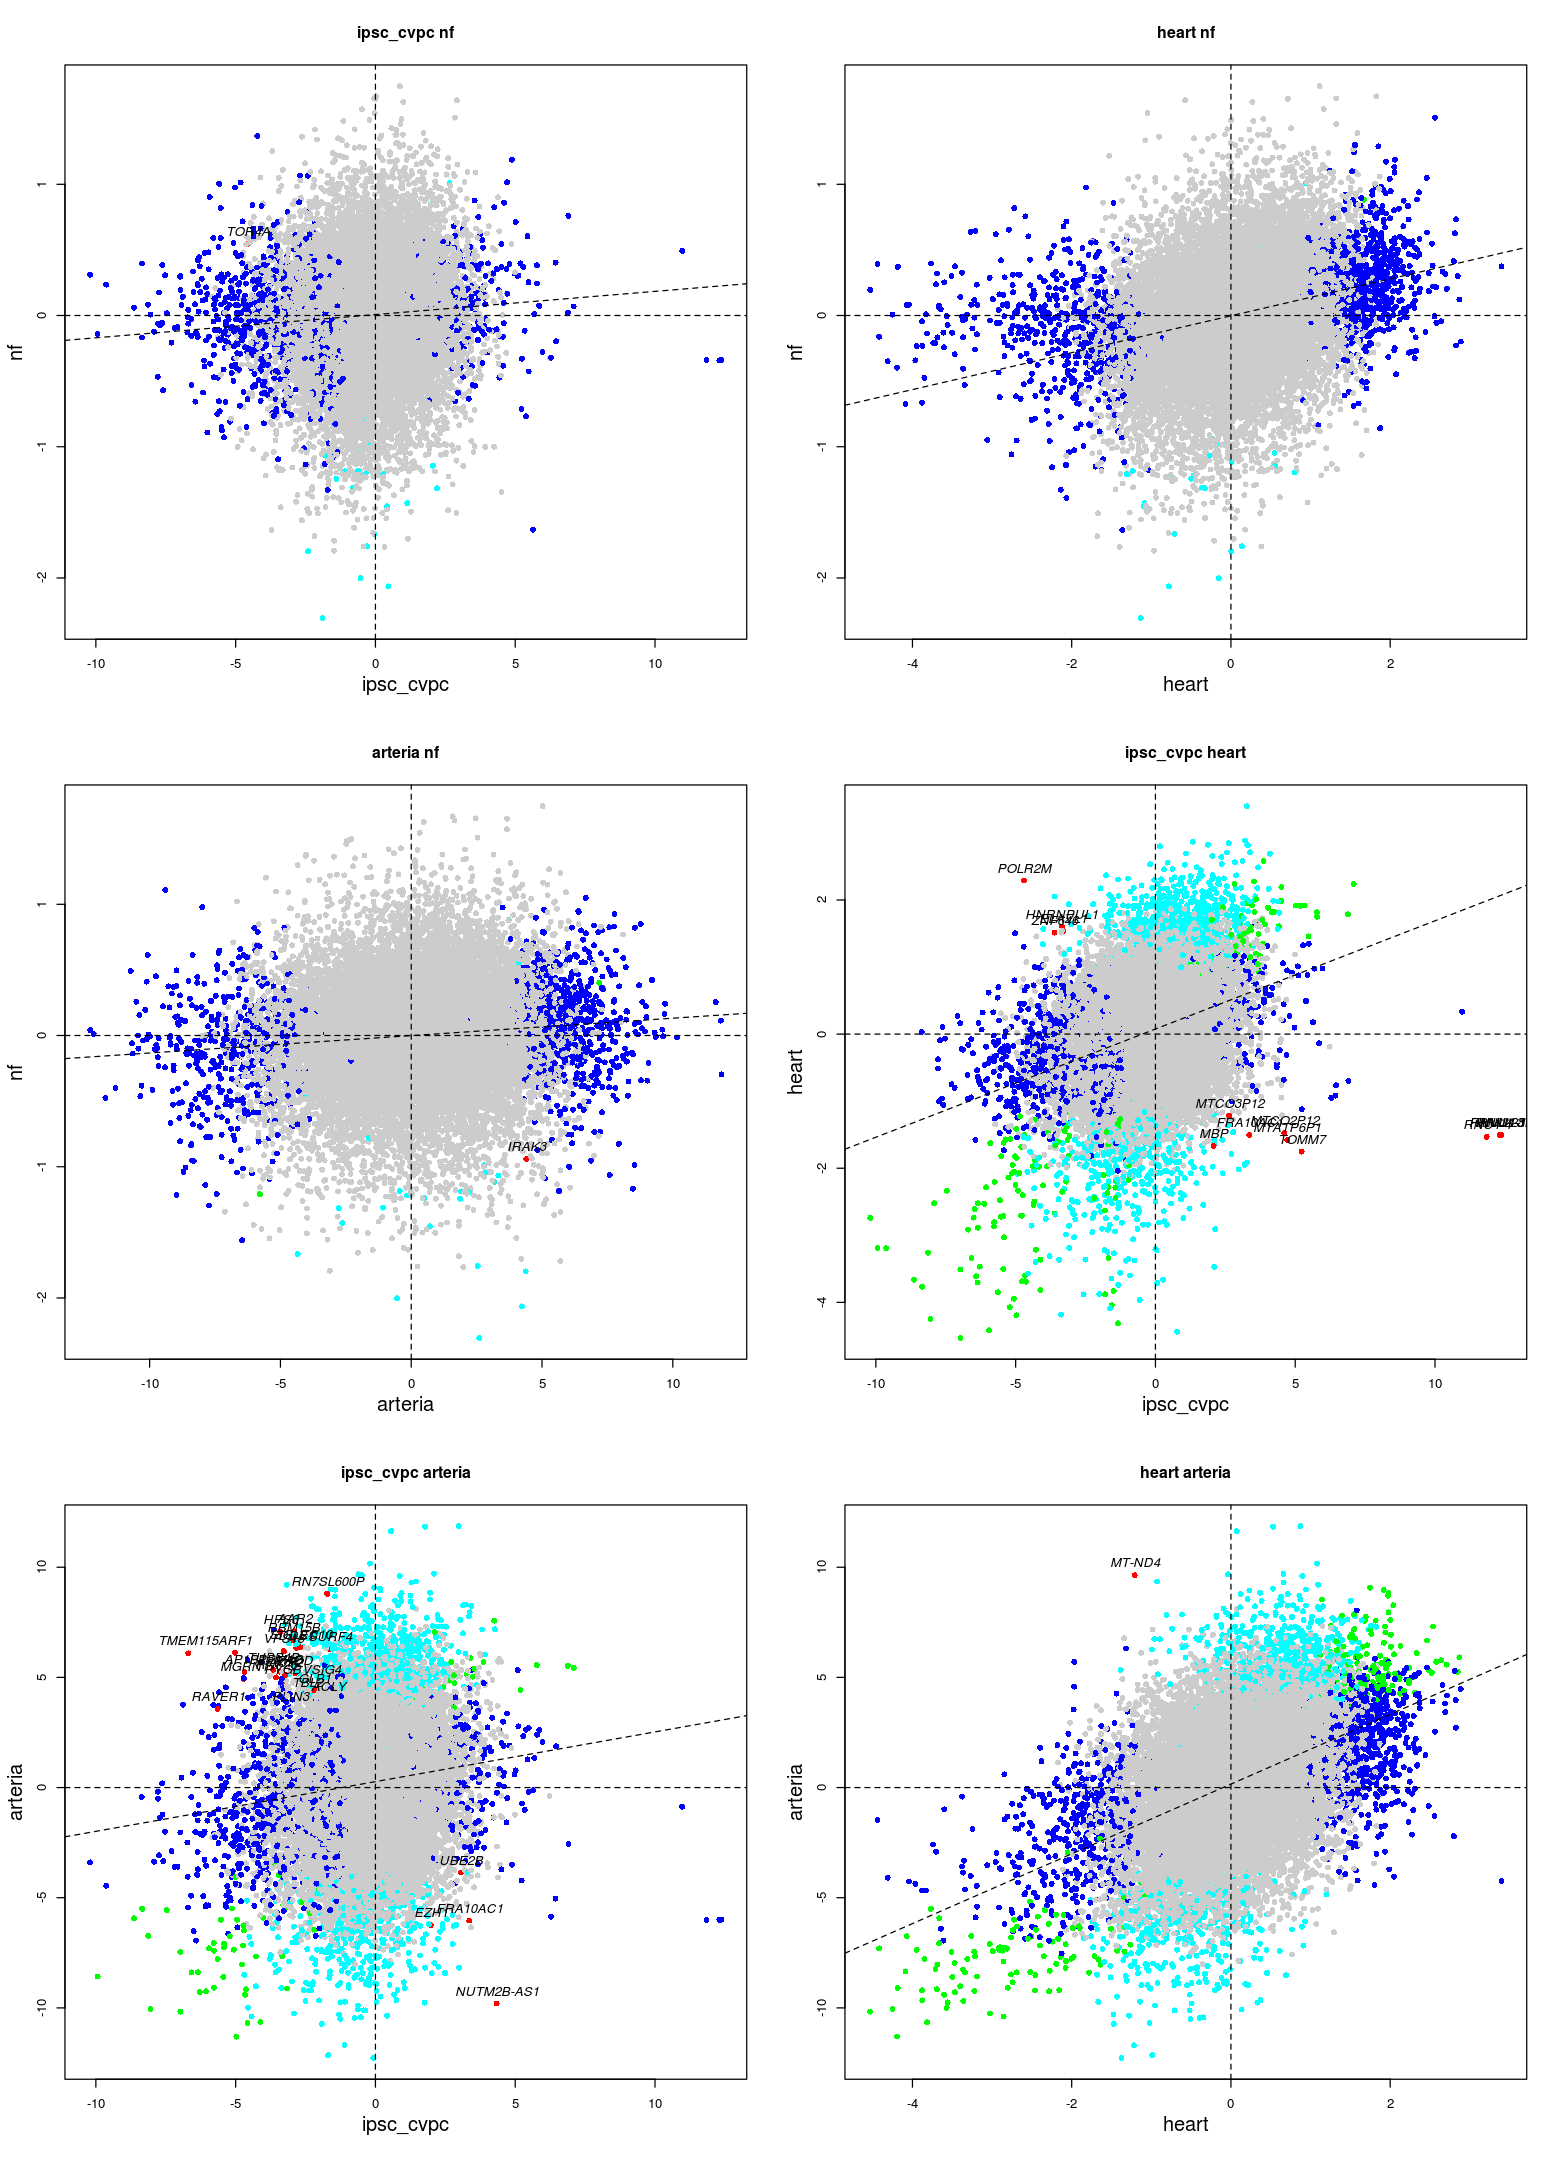

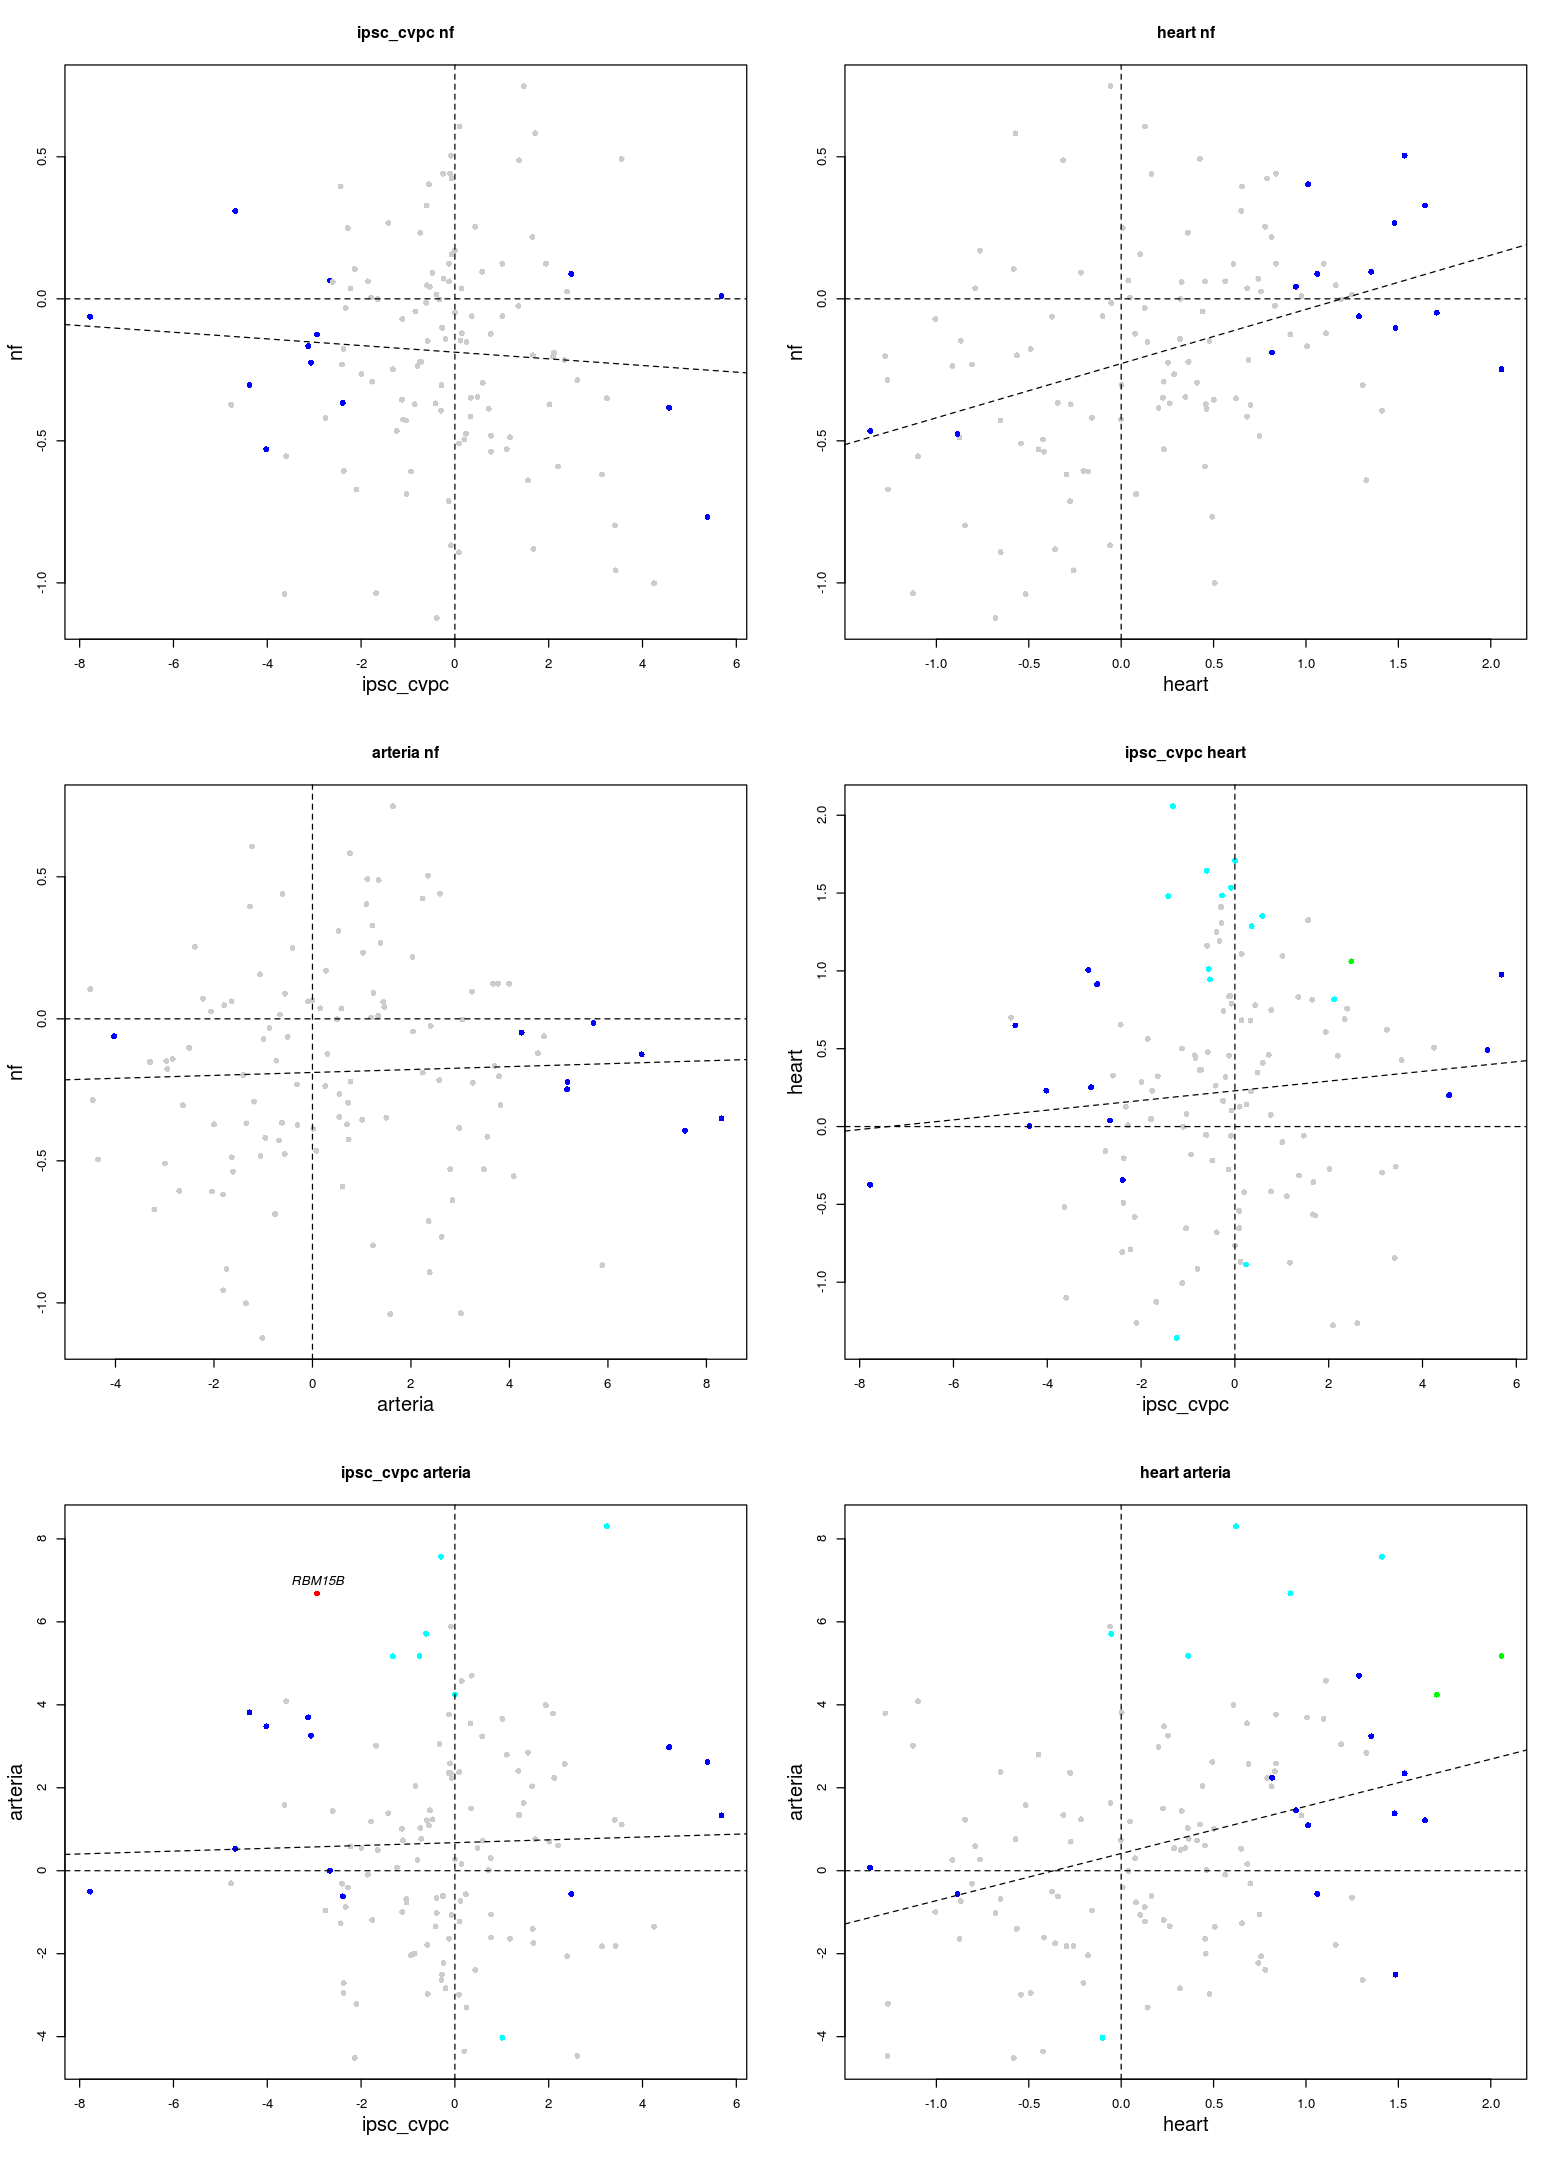

In [274]:
plot_diffexp = function(type, tissue1, tissue2, diffexp)
{
    d1 = diffexp[ diffexp$type == type & diffexp$covariate == "tissue" & diffexp$tissue1 == "hf" & diffexp$tissue2 == tissue1,]
    d2 = diffexp[ diffexp$type == type & diffexp$covariate == "tissue" & diffexp$tissue1 == "hf" & diffexp$tissue2 == tissue2, ]
    
    diffexp = merge(d1[,c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")],
                    d2[,c("transcript_id", "gene_id", "gene_name", "beta", "pval", "qval", "diffexp")],
                    by = c("transcript_id", "gene_id", "gene_name"),
                    suffixes = 1:2
                   )
    
    diffexp$color = "#cccccc"
    
    
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE  & sign(diffexp$beta1) == sign(diffexp$beta2), "color"] = "#00ff00"
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == TRUE  & sign(diffexp$beta1) != sign(diffexp$beta2), "color"] = "#ff0000"
    diffexp[ diffexp$diffexp1 == TRUE  & diffexp$diffexp2 == FALSE, "color"] = "#0000ff"
    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == TRUE , "color"] = "#00ffff"
    diffexp[ diffexp$diffexp1 == FALSE & diffexp$diffexp2 == FALSE, "color"] = "#cccccc"
    
    plot(diffexp$beta1, diffexp$beta2, col = diffexp$color, pch = 16, main = paste(tissue1, tissue2), xlab = "", ylab = "")
    #plot(diffexp$log2r  , diffexp$beta_ridge, col = diffexp$color, pch = 16)
    mtext(text = tissue1, side = 1, line = 2.5)
    mtext(text = tissue2, side = 2, line = 2.5)
    
    abline(v = 0, lty = "dashed")
    abline(h = 0, lty = "dashed")
    abline(lm(beta2 ~ beta1, data = diffexp), lty = "dashed")
    
    if(nrow(diffexp[diffexp$color == "#ff0000",]) > 0)
    {
        x = diffexp[diffexp$color == "#ff0000",]
        
        text(x = x$beta1, y = x$beta2, labels = x$gene_name, font = 3, pos = 3)
    }
    
    mycor = cor.test(diffexp$beta1, diffexp$beta2)
    
    #diffexp = diffexp[is.infinite(diffexp$log2r) == FALSE,]
    
    #mycor = cor.test(diffexp$log2r, diffexp$beta_ridge)
    
    message(paste(type, tissue1, tissue2, mycor$estimate, mycor$p.value))
}

options(repr.plot.width = 13, repr.plot.height = 18)
layout(matrix(1:6, nrow = 3, byrow = TRUE))


message("**********************************\nAll genes")

plot_diffexp("gene_tpm"   , "ipsc_cvpc", "nf"     , diffexp)
plot_diffexp("gene_tpm"   , "heart"    , "nf"     , diffexp)
plot_diffexp("gene_tpm"   , "arteria"  , "nf"     , diffexp)
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "heart"  , diffexp)
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "arteria", diffexp)
plot_diffexp("gene_tpm"   , "heart"    , "arteria", diffexp)

message("**********************************\nRBPs")

plot_diffexp("gene_tpm"   , "ipsc_cvpc", "nf"     , diffexp[diffexp$gene_name %in% rbps,])
plot_diffexp("gene_tpm"   , "heart"    , "nf"     , diffexp[diffexp$gene_name %in% rbps,])
plot_diffexp("gene_tpm"   , "arteria"  , "nf"     , diffexp[diffexp$gene_name %in% rbps,])
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "heart"  , diffexp[diffexp$gene_name %in% rbps,])
plot_diffexp("gene_tpm"   , "ipsc_cvpc", "arteria", diffexp[diffexp$gene_name %in% rbps,])
plot_diffexp("gene_tpm"   , "heart"    , "arteria", diffexp[diffexp$gene_name %in% rbps,])


#plot_diffexp("gene_tpm"   , "ipsc_cvpc", "heart"  , diffexp_hf, diffexp_de)
#plot_diffexp("gene_tpm"   , "ipsc_cvpc", "arteria", diffexp_hf, diffexp_de)
#plot_diffexp("gene_tpm"   , "heart"    , "arteria", diffexp_hf, diffexp_de)
#plot.new()
#message("**********************************\nRBPs")
#plot_diffexp("gene_tpm"   , "ipsc_cvpc", "heart"  , diffexp_hf[ diffexp_hf$gene_name %in% rbps,], diffexp_de)
#plot_diffexp("gene_tpm"   , "ipsc_cvpc", "arteria", diffexp_hf[ diffexp_hf$gene_name %in% rbps,], diffexp_de)
#plot_diffexp("gene_tpm"   , "heart"    , "arteria", diffexp_hf[ diffexp_hf$gene_name %in% rbps,], diffexp_de)
#plot.new()
#message("**********************************\nIsoforms")
#plot_diffexp("isoform_use", "ipsc_cvpc", "heart"  , diffexp_hf, diffexp_de)
#plot_diffexp("isoform_use", "ipsc_cvpc", "arteria", diffexp_hf, diffexp_de)
#plot_diffexp("isoform_use", "heart"    , "arteria", diffexp_hf, diffexp_de)




In [269]:
a = diffexp[ diffexp$diffexp1 == TRUE & diffexp$diffexp2 == TRUE,]
a[order(a$pval1, decreasing = FALSE),]

ERROR: Error in order(a$pval1, decreasing = FALSE): argument 1 is not a vector


In [146]:
a = diffexp_all[ diffexp_all$diffexp_hf == TRUE & diffexp_all$gene_name %in% rbps,]
a[order(a$pval_hf, decreasing = FALSE),]

,transcript_id,gene_id,gene_name,type,beta_hf,pval_hf,qval_hf,diffexp_hf,tissue1,tissue2,beta_de,pval_de,qval_de,diffexp_de
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
12988,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,heart,-0.2626361,0.108701414,1,FALSE
12989,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,heart,arteria,0.2450826,0.253333681,1,FALSE
12990,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,arteria,-0.8377990,0.005722736,1,FALSE


In [149]:
a = diffexp_all[ diffexp_all$type == "gene_tpm" & diffexp_all$gene_name %in% rbps & diffexp_all$tissue1 == "",]
a[order(a$pval_hf, decreasing = FALSE),]



,transcript_id,gene_id,gene_name,type,beta_hf,pval_hf,qval_hf,diffexp_hf,tissue1,tissue2,beta_de,pval_de,qval_de,diffexp_de
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
12988,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,heart,-0.2626361475,1.087014e-01,1.000000e+00,FALSE
12989,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,heart,arteria,0.2450825861,2.533337e-01,1.000000e+00,FALSE
12990,ENSG00000119707.14_5,ENSG00000119707.14_5,RBM25,gene_tpm,-0.7673808,3.467973e-07,0.007029928,TRUE,ipsc_cvpc,arteria,-0.8377989791,5.722736e-03,1.000000e+00,FALSE
28579,ENSG00000164548.11_5,ENSG00000164548.11_5,TRA2A,gene_tpm,-0.9559485,2.182722e-04,1.000000000,FALSE,ipsc_cvpc,arteria,-0.8034163897,9.044716e-03,1.000000e+00,FALSE
28580,ENSG00000164548.11_5,ENSG00000164548.11_5,TRA2A,gene_tpm,-0.9559485,2.182722e-04,1.000000000,FALSE,heart,arteria,0.9223107652,1.123833e-04,1.000000e+00,FALSE
28581,ENSG00000164548.11_5,ENSG00000164548.11_5,TRA2A,gene_tpm,-0.9559485,2.182722e-04,1.000000000,FALSE,ipsc_cvpc,heart,-0.0001452816,9.993427e-01,1.000000e+00,FALSE
6052,ENSG00000100320.23_7,ENSG00000100320.23_7,RBFOX2,gene_tpm,0.5040814,1.003343e-03,1.000000000,FALSE,ipsc_cvpc,heart,2.0881773504,2.833573e-66,5.778505e-62,TRUE
6053,ENSG00000100320.23_7,ENSG00000100320.23_7,RBFOX2,gene_tpm,0.5040814,1.003343e-03,1.000000000,FALSE,heart,arteria,-0.6075583490,2.452435e-04,1.000000e+00,FALSE
6054,ENSG00000100320.23_7,ENSG00000100320.23_7,RBFOX2,gene_tpm,0.5040814,1.003343e-03,1.000000000,FALSE,ipsc_cvpc,arteria,0.9892376701,1.144068e-06,2.333099e-02,TRUE


In [270]:
diffexp

transcript_id,gene_id,gene_name,gene_type,covariate,beta,se,pval,qval,tissue1,tissue2,type,diffexp
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<lgl>
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,endocardial,0.977557951,1.117812248,0.6762375281,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,myofibroblast,-2.195907738,1.634739558,0.2983218466,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,cardiac_muscle,-0.098930891,0.342088332,1.0000000000,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,sex,0.190700134,0.080058728,0.0172187548,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,immune,3.193203086,3.551020632,0.4458069370,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,fibroblast,2.152888176,3.093314555,0.5900088541,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,endothelial,-0.552481387,1.397485873,0.9696972114,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,mitochondrial_reads,0.053275631,0.023446088,0.0230707494,1,hf,ipsc_cvpc,gene_tpm,FALSE
ENSG00000000003.15_5,ENSG00000000003.15_5,TSPAN6,protein_coding,total_reads_norm,0.262000127,0.265102281,0.3230065897,1,hf,ipsc_cvpc,gene_tpm,FALSE
